In [1]:
# 구글 드라이브 임포트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# konlpy 및 mecab 다운로드
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 122 (delta 15), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (122/122), 1.27 MiB | 22.86 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 53.4 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-06-04 06:07:23--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::6b17:d1f5, 2406:da00:ff00::3403:4be7, ...
Connecting to bitbu

In [3]:
import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt, Mecab
from konlpy.utils import pprint
from konlpy.tag import Mecab

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/Othkkartho/abuse_division/master/data/origin_final.csv", filename="dataset.csv")

('dataset.csv', <http.client.HTTPMessage at 0x7f2936d7e710>)

In [6]:
total_data = pd.read_csv('dataset.csv', encoding = "utf-8")
print('전체 리뷰 개수 :',len(total_data)) # 전체 댓글 개수 출력

전체 리뷰 개수 : 11088


In [7]:
total_data[:5]

,text,label
0,좌배 까는건 ㅇㅂ,1
1,집에 롱 패딩만 세 개다. 10년 더 입어야지 ㅋㅋ,0
2,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,1
3,세탁이라고 봐도 된다,0
4,애새끼가 초딩도 아니고 ㅋㅋㅋㅋ,1


In [8]:
print('데이터에 Null 값이 있는지 유무 : ' + str(total_data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


In [9]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
total_data.isnull().sum()

어떤 열에 Null값이 있는지 출력


text     0
label    0
dtype: int64

In [10]:
# text 열과 label 열의 중복을 제외한 값의 개수
total_data['text'].nunique(), total_data['label'].nunique()

(10940, 2)

In [11]:
total_data.drop_duplicates(subset=['text'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 10940


In [12]:
#3:1로 train, test 데이터셋 나누기
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 8205
테스트용 리뷰의 개수 : 2735


<Axes: >

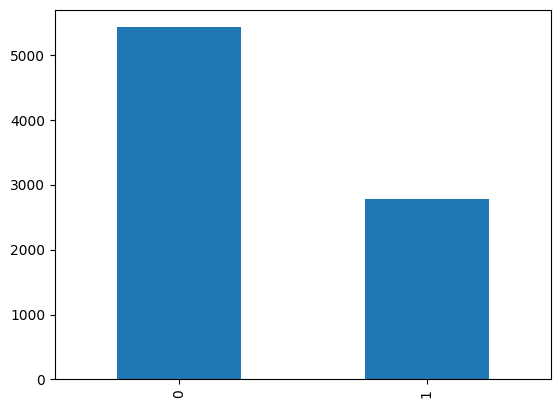

In [13]:
#라벨별 train 데이터셋 출력
train_data['label'].value_counts().plot(kind = 'bar')

<Axes: >

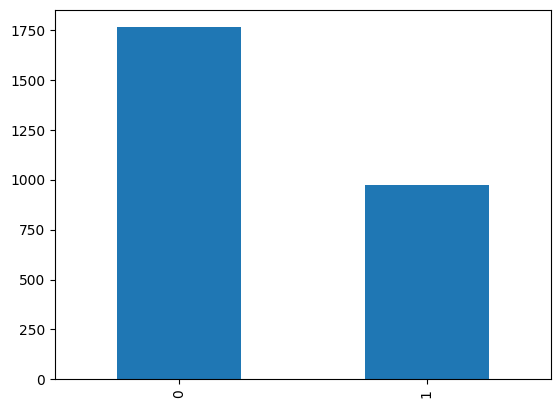

In [14]:
#라벨별 test 데이터셋 출력
test_data['label'].value_counts().plot(kind = 'bar')

In [15]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   5425
1      1   2780


In [16]:
# 한글과 공백을 제외하고 모두 제거
train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
#train_data['text'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

text     0
label    0
dtype: int64


<ipython-input-16-ab6011aefac3>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [17]:
test_data.drop_duplicates(subset = ['text'], inplace=True) # 중복 제거
test_data['text'] = test_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
#test_data['text'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 2735


<ipython-input-17-428751208323>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['text'] = test_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [18]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '되', '음', '면']

In [19]:
#토큰화
okt = Mecab() 

train_data['tokenized'] = train_data['text'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['text'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [20]:
negative_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)

In [21]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('ㅋㅋㅋ', 994), ('거', 533), ('새끼', 479), ('ㅋㅋ', 460), ('있', 325), ('아', 313), ('나', 287), ('냐', 282), ('안', 262), ('로', 248), ('어', 234), ('노', 222), ('말', 218), ('개', 217), ('보', 215), ('니', 212), ('같', 207), ('으로', 205), ('는데', 195), ('병신', 195)]


In [22]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('거', 608), ('있', 553), ('ㅋㅋㅋ', 487), ('안', 390), ('나', 375), ('냐', 353), ('ㅋㅋ', 342), ('없', 340), ('어', 339), ('는데', 324), ('ㄷ', 308), ('로', 301), ('아', 285), ('으로', 271), ('아니', 263), ('말', 249), ('에서', 247), ('보', 243), ('노', 231), ('었', 219)]


긍정 리뷰의 평균 길이 : 14.9931654676259
부정 리뷰의 평균 길이 : 8.748571428571429


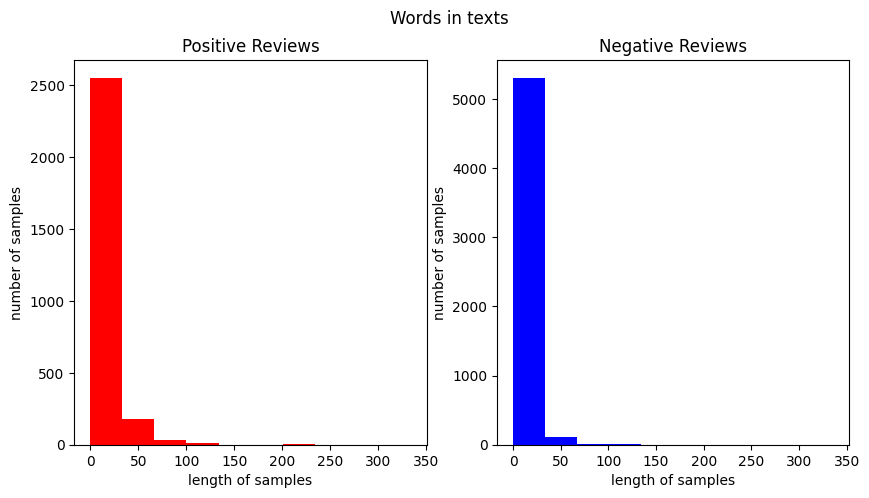

In [23]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [24]:
#토큰화된 문장으로 변경
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [25]:
#인코딩된 문장으로 변경
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [26]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 13780
등장 빈도가 1번 이하인 희귀 단어의 수: 7423
단어 집합에서 희귀 단어의 비율: 53.86792452830189
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.3271634022122


In [27]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6359


In [28]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [29]:
print(X_train[:3])
print(X_train[0][0])

[[2575, 1847, 414, 40], [184, 439, 352, 1451, 10, 397, 362, 146, 101, 14, 1, 3, 624, 1848, 3164, 899, 14, 1, 9, 78, 559, 1306, 20, 3165, 2141, 674, 10, 64, 1619, 835, 119, 19, 244, 398, 63, 1620, 20, 1, 1619, 1, 63, 155, 126, 709, 2576, 4154, 4, 13, 1, 205, 675, 23, 150, 31, 3, 306, 299, 14, 64, 1619, 3165, 1306, 151, 407, 24, 4155, 3166, 93, 3167, 34, 148, 19, 255, 249], [2142]]
2575


In [30]:
print(X_test[:3])

[[24, 1, 145, 159, 17, 24, 392, 16, 360, 735, 1217, 73, 83, 34, 379, 631, 283, 24, 57, 1463, 16, 7, 139, 113, 207, 61, 2565, 2566, 1194, 42, 1748, 3728, 1, 1, 44, 1, 1617, 89, 1137, 1563, 1, 32, 15, 10, 4, 127, 3, 1245, 52, 5283, 72, 560, 236, 229, 1220, 2089, 1, 1563, 115, 581, 15, 1729, 324, 2916, 679, 1, 435, 157, 2175, 1, 20, 1323, 4124, 1251, 1, 1, 15, 1558, 2108, 324, 756, 1426, 208, 32, 800, 32, 1, 476, 20, 1, 258, 1761, 259, 1, 379, 3, 292, 3], [3005, 699, 78, 967, 18, 5, 5, 103, 38, 9, 2, 2, 2, 2, 5], [1083, 712, 2574, 36, 35, 321, 39, 1, 2574, 36, 233, 1, 45, 12]]


리뷰의 최대 길이 : 336
리뷰의 평균 길이 : 10.86435100548446


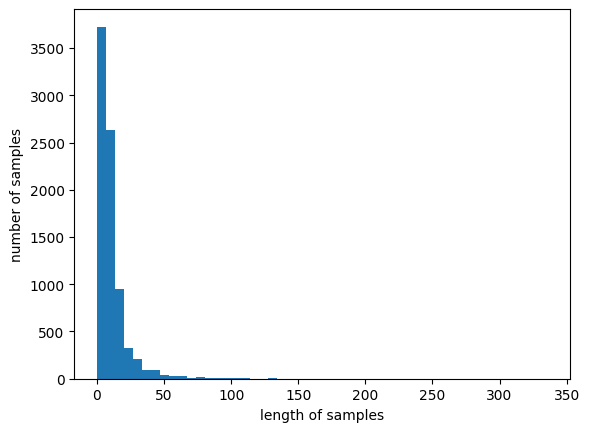

In [31]:
print('댓글의 최대 길이 :',max(len(review) for review in X_train))
print('댓글의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [33]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 98.18403412553322


In [34]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [35]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D, Reshape, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 256 # 임베딩 벡터의 차원
dropout_ratio = 0.3 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 5 # 커널의 크기
hidden_units = 128 # 뉴런의 수

In [36]:
# # 학습을 하려면 주석 전체를 제거
# # LSTM 정상작동 코드
# model_LSTM = Sequential()
# model_LSTM.add(Embedding(vocab_size, embedding_dim))
# model_LSTM.add(LSTM(hidden_units)) # LSTM을 사용
# model_LSTM.add(Dense(1, activation='sigmoid'))

# # CNN 정상작동 코드
# model_CNN = Sequential()
# model_CNN.add(Embedding(vocab_size, embedding_dim))
# model_CNN.add(Dropout(dropout_ratio))
# model_CNN.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
# model_CNN.add(GlobalMaxPooling1D())
# model_CNN.add(Dense(hidden_units, activation='relu'))
# model_CNN.add(Dropout(dropout_ratio))
# model_CNN.add(Dense(1, activation='sigmoid'))


# import numpy as np

# # # CNN-LSTM 코드(Conv-MaxPooling-LSTM)
# # model = Sequential()
# # model.add(Embedding(vocab_size, embedding_dim))
# # model.add(Dropout(dropout_ratio))
# # model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
# # model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
# # model.add(GlobalMaxPooling1D())
# # model.add(Reshape((1, -1))) # GlobalMaxPooling1D() 결과 3D Matrix로 변환
# # model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
# # model.add(Dense(hidden_units, activation='relu'))
# # model.add(Dropout(dropout_ratio))
# # model.add(Dense(1, activation='sigmoid'))

# # # CNN-LSTM 코드(Conv-MaxPooling-Conv-MaxPooling-LSTM)
# # model = Sequential()
# # model.add(Embedding(vocab_size, embedding_dim))
# # # model.add(Dropout(dropout_ratio))
# # model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
# # model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
# # model.add(MaxPooling1D(pool_size=10, strides=1))
# # model.add(Conv1D(num_filters, 1, padding='valid', activation='relu'))
# # model.add(GlobalMaxPooling1D())
# # model.add(Reshape((1, -1))) # GlobalMaxPooling1D() 결과 3D Matrix로 변환
# # model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
# # model.add(Dense(hidden_units, activation='relu'))
# # model.add(Dropout(dropout_ratio))
# # model.add(Dense(1, activation='sigmoid'))

# # CNN-LSTM 코드(Conv-MaxPooling-Conv-MaxPooling-LSTM v0.2)
# model_CL = Sequential()
# model_CL.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
# model_CL.add(Dropout(dropout_ratio))
# model_CL.add(Conv1D(10, kernel_size, padding='valid', activation='relu', data_format='channels_first'))
# #model_CL.add(Conv1D(10, kernel_size, padding='valid', activation='relu', data_format='channels_first'))
# # model.add(MaxPooling1D(pool_size=10, strides=1))
# # model.add(Conv1D(num_filters, 1, padding='valid', activation='relu'))
# model_CL.add(GlobalMaxPooling1D())
# model_CL.add(Reshape((1, -1))) # GlobalMaxPooling1D() 결과 3D Matrix로 변환
# model_CL.add(Dropout(dropout_ratio))
# model_CL.add(LSTM(hidden_units)) # LSTM을 사용
# model_CL.add(Dense(hidden_units, activation='relu'))
# model_CL.add(Dropout(dropout_ratio))
# model_CL.add(Dense(1, activation='sigmoid'))

# # model.summary()

1. 임베딩벡터레이어에서 임베딩 벡터를 생성함. 이때 임베딩   
   벡터 테이블(voca_size, embedding_dim)형태의 임베딩 벡터 테이블이 생성됨
   반환을 할 때는 (채널, 입력 문장의 길이, 임베딩벡터차원)형태로 반환함
   keras의 embedding과 gensim의 word2vec은 차이가 있는데
   케라스의 경우 단어를 임베딩하고 학습하는 형태이지만 word2vec은 주변 단어와의 관계를 고려하여 학습하게 된다. 임베딩은 주변단어와의 관계를 고려하지 않기 때문에 word2vec과 차이점을 가진다. 여기서는 embedding 의 값에서 특징을 추출하는 방식으로 학습을 시킨다.

2. Conv1D레이어에서는 위 계층에서 나온 값들의 특징들을 
   추출한다. 총 10개 필터를 이용해 커널 사이즈만큼 움직이면서 특징들을 추출한 후 channels_first 속성을 이용해서 (배치, 채널, 임베딩벡터차원) 형태로 값을 반환한다.

3. GlobalMaxPooling1D를 이용하여 위에서 나온 텐서에서 각 
   필터들이 만들어낸 값중 가장 큰 값을 뽑아와서 (배치, 단어) 형태로 반환한다. 이때 배치는 입력된 문장의 개수이고 단어는 그 문장을 이루는 단어에 필터를 적용한 값중 가장 큰 값을 뽑아낸 필터의 값을 갖는다.

4. 위 특징을 뽑아낸 값을 가지고 LSTM에 학습을 시킨다.
5. Dense레이어에 LSTM학습 결과 값을 넣고 0, 1로 값을 반환한다



In [39]:
# # 학습시 전체 주석 제거
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc_CNN = ModelCheckpoint('CNN_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# mc_LSTM = ModelCheckpoint('LSTM_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# mc_CL = ModelCheckpoint('CNN_LSTM_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# model_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# model_CL.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# history_CNN = model_CNN.fit(X_train, y_train, epochs=15, callbacks=[mc_CNN, es], batch_size=64, validation_split=0.2)
# history_LSTM = model_LSTM.fit(X_train, y_train, epochs=15, callbacks=[mc_LSTM, es], batch_size=64, validation_split=0.2)
# history_CL = model_CL.fit(X_train, y_train, epochs=15, callbacks=[mc_CL, es], batch_size=64, validation_split=0.2)

Epoch 1/15
103/103 [==============================] - ETA: 0s - loss: 0.5382 - acc: 0.7407
Epoch 1: val_acc improved from -inf to 0.83120, saving model to CNN_best_model.h5
103/103 [==============================] - 26s 154ms/step - loss: 0.5382 - acc: 0.7407 - val_loss: 0.4134 - val_acc: 0.8312
Epoch 2/15
103/103 [==============================] - ETA: 0s - loss: 0.3095 - acc: 0.8810
Epoch 2: val_acc improved from 0.83120 to 0.84948, saving model to CNN_best_model.h5
103/103 [==============================] - 7s 71ms/step - loss: 0.3095 - acc: 0.8810 - val_loss: 0.3948 - val_acc: 0.8495
Epoch 3/15
103/103 [==============================] - ETA: 0s - loss: 0.1872 - acc: 0.9375
Epoch 3: val_acc did not improve from 0.84948
103/103 [==============================] - 6s 53ms/step - loss: 0.1872 - acc: 0.9375 - val_loss: 0.4403 - val_acc: 0.8221
Epoch 4/15
103/103 [==============================] - ETA: 0s - loss: 0.1124 - acc: 0.9634
Epoch 4: val_acc did not improve from 0.84948
103/103 [

In [40]:
# #학습된 모델 로컬에 저장
# loaded_model_CNN = load_model('CNN_best_model.h5')
# loaded_model_LSTM = load_model('LSTM_best_model.h5')
# loaded_model_CL = load_model('CNN_LSTM_best_model.h5')

# 구글 드라이브에서 모델 불러오기
loaded_model_CNN = load_model('/content/drive/MyDrive/abuse_division/data/CNN_best_model.h5')
loaded_model_LSTM = load_model('/content/drive/MyDrive/abuse_division/data/LSTM_best_model.h5')
loaded_model_CL = load_model('/content/drive/MyDrive/abuse_division/data/CNN_LSTM_best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model_CNN.evaluate(X_test, y_test)[1]))
print("테스트 정확도: %.4f" % (loaded_model_LSTM.evaluate(X_test, y_test)[1]))
print("테스트 정확도: %.4f" % (loaded_model_CL.evaluate(X_test, y_test)[1]))

86/86 [==============================] - 0s 3ms/step - loss: 0.4217 - acc: 0.8399
테스트 정확도: 0.8399
86/86 [==============================] - 1s 3ms/step - loss: 0.4431 - acc: 0.8197
테스트 정확도: 0.8197
86/86 [==============================] - 1s 3ms/step - loss: 0.4889 - acc: 0.7909
테스트 정확도: 0.7909


In [41]:
# 욕설 예측 함수
def abuse_predict(new_sentence, loaded_model=True):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩

  if loaded_model:
    score_CNN = float(loaded_model_CNN.predict(pad_new)) # CNN 예측
    score_LSTM = float(loaded_model_LSTM.predict(pad_new)) # LSTM 예측
    score_CL = float(loaded_model_CL.predict(pad_new)) # CNN-LSTM 예측
    
  else:
    score_CNN = float(model_CNN.predict(pad_new)) # CNN 예측
    score_LSTM = float(model_LSTM.predict(pad_new)) # LSTM 예측
    score_CL = float(model_CL.predict(pad_new)) # CNN-LSTM 예측
  
  print('CNN 예측값', end=" ")
  if(score_CNN > 0.5): print("{:.2f}% 확률로 부정 댓글입니다.".format(score_CNN * 100))
  else:print("{:.2f}% 확률로 정상 댓글입니다.".format((1 - score_CNN) * 100))

  print('LSTM 예측값', end=" ")
  if(score_LSTM > 0.5): print("{:.2f}% 확률로 부정 댓글입니다.".format(score_LSTM * 100))
  else:print("{:.2f}% 확률로 정상 댓글입니다.".format((1 - score_LSTM) * 100))

  print('CNN-LSTM 예측값', end=" ")
  if(score_CL > 0.5): print("{:.2f}% 확률로 부정 댓글입니다.".format(score_CL * 100))
  else:print("{:.2f}% 확률로 정상 댓글입니다.".format((1 - score_CL) * 100))

In [42]:
abuse_predict('노잼 ..완전 재미 없음 ㅉㅉ')

1/1 [==============================] - 0s 367ms/step
CNN 예측값 96.62% 확률로 정상 댓글입니다.
LSTM 예측값 69.56% 확률로 정상 댓글입니다.
CNN-LSTM 예측값 57.14% 확률로 정상 댓글입니다.


In [43]:
abuse_predict('조금 어렵지만 재밌음ㅋㅋ')

1/1 [==============================] - 0s 17ms/step
CNN 예측값 97.17% 확률로 정상 댓글입니다.
LSTM 예측값 88.55% 확률로 정상 댓글입니다.
CNN-LSTM 예측값 99.27% 확률로 정상 댓글입니다.


In [44]:
abuse_predict('캐릭터가 예뻐서 좋아요')

1/1 [==============================] - 0s 21ms/step
CNN 예측값 96.49% 확률로 정상 댓글입니다.
LSTM 예측값 91.65% 확률로 정상 댓글입니다.
CNN-LSTM 예측값 98.83% 확률로 정상 댓글입니다.


In [45]:
abuse_predict('조센징답다 열등종 센숭이')

1/1 [==============================] - 0s 18ms/step
CNN 예측값 91.47% 확률로 정상 댓글입니다.
LSTM 예측값 71.49% 확률로 정상 댓글입니다.
CNN-LSTM 예측값 61.37% 확률로 부정 댓글입니다.


In [46]:
abuse_predict("미친 새끼 또 저 지랄이네 대단하다 대단해")

1/1 [==============================] - 0s 18ms/step
CNN 예측값 99.42% 확률로 부정 댓글입니다.
LSTM 예측값 99.05% 확률로 부정 댓글입니다.
CNN-LSTM 예측값 99.45% 확률로 부정 댓글입니다.


In [47]:
abuse_predict("안녕하세요 오랜만에 뵈요. 어떤일 하고 있나요?")

1/1 [==============================] - 0s 18ms/step
CNN 예측값 93.66% 확률로 정상 댓글입니다.
LSTM 예측값 90.83% 확률로 정상 댓글입니다.
CNN-LSTM 예측값 96.94% 확률로 정상 댓글입니다.


In [48]:
abuse_predict("정게로 꺼져라")

1/1 [==============================] - 0s 19ms/step
CNN 예측값 96.04% 확률로 정상 댓글입니다.
LSTM 예측값 86.23% 확률로 정상 댓글입니다.
CNN-LSTM 예측값 97.44% 확률로 정상 댓글입니다.


In [49]:
abuse_predict(" 저거 다이소에도 있음")

1/1 [==============================] - 0s 19ms/step
CNN 예측값 96.83% 확률로 정상 댓글입니다.
LSTM 예측값 93.80% 확률로 정상 댓글입니다.
CNN-LSTM 예측값 97.92% 확률로 정상 댓글입니다.


In [50]:
abuse_predict("어떻게 됐건 민주당이 180석인데 건드리기 힘들지 병신련아 ㅋㅋㅋㅋㅋㅋㅋㅋ")

1/1 [==============================] - 0s 19ms/step
CNN 예측값 69.63% 확률로 정상 댓글입니다.
LSTM 예측값 80.64% 확률로 부정 댓글입니다.
CNN-LSTM 예측값 71.08% 확률로 부정 댓글입니다.


In [51]:
abuse_predict("홍어 먹어봤음?")

1/1 [==============================] - 0s 19ms/step
CNN 예측값 58.01% 확률로 부정 댓글입니다.
LSTM 예측값 64.01% 확률로 정상 댓글입니다.
CNN-LSTM 예측값 51.22% 확률로 정상 댓글입니다.


In [52]:
abuse_predict("전라도 홍어 먹어봤음?")

1/1 [==============================] - 0s 19ms/step
CNN 예측값 80.68% 확률로 부정 댓글입니다.
LSTM 예측값 53.87% 확률로 부정 댓글입니다.
CNN-LSTM 예측값 66.54% 확률로 부정 댓글입니다.


위 데이터에서 븅신은 병신과 같은 의미이지만 병신과 븅신을 정확히 구별하지 못하는 부분이 있다. 븅을 병으로 바꾸면 높은 확률로 부정적이라고 판별한다.

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# confusion matrix 그래프 함수
def ConfusionMatrixGraph(predict, y_test):

  y_predict = np.where(predict > 0.5, 1, 0)
  y_test = np.array(y_test)

  labels = [0, 1]

  cm = confusion_matrix(y_test, y_predict)
  print(cm)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

  accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
  print("정확도 : ", accuracy)
  recall = cm[1][1] / (cm[1][1] + cm[0][1])
  print("재현율 : ", recall)
  precision = cm[1][1] / (cm[1][0] + cm[1][1])
  print("정밀도 : ", precision)
  F1Score = (2 * precision * recall) / (precision + recall)
  print("F1Score : ", F1Score)

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

In [54]:
# 각 모델에 대한 confusion matrix 출력
def showModelConfusion(loaded_model=True):
  
  if loaded_model:
    y_pred_CNN = np.array(loaded_model_CNN.predict(X_test))
    y_pred_LSTM = np.array(loaded_model_LSTM.predict(X_test))
    y_pred_CL = np.array(loaded_model_CL.predict(X_test))
  else:
    y_pred_CNN = np.array(model_CNN.predict(X_test))
    y_pred_LSTM = np.array(model_LSTM.predict(X_test))
    y_pred_CL = np.array(model_CL.predict(X_test))

  print("CNN")
  ConfusionMatrixGraph(y_pred_CNN, y_test)

  print("LSTM")
  ConfusionMatrixGraph(y_pred_LSTM, y_test)

  print("CNN-LSTM")
  ConfusionMatrixGraph(y_pred_CL, y_test)


86/86 [==============================] - 0s 2ms/step
CNN
[[1629  134]
 [ 304  668]]
정확도 :  0.839853747714808
재현율 :  0.8329177057356608
정밀도 :  0.6872427983539094
F1Score :  0.7531003382187147


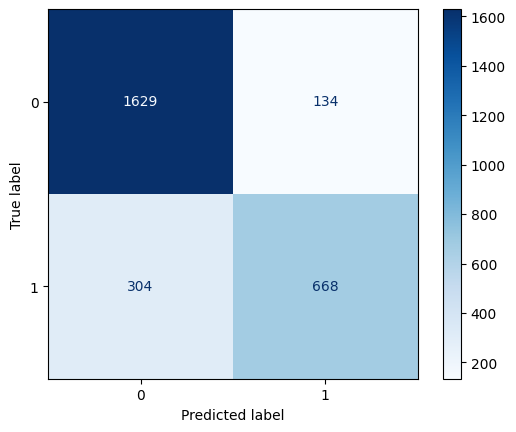

LSTM
[[1636  127]
 [ 366  606]]
정확도 :  0.819744058500914
재현율 :  0.8267394270122783
정밀도 :  0.6234567901234568
F1Score :  0.7108504398826978


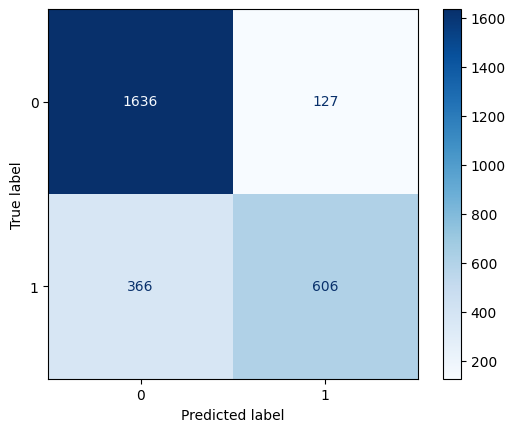

CNN-LSTM
[[1516  247]
 [ 325  647]]
정확도 :  0.7908592321755027
재현율 :  0.7237136465324385
정밀도 :  0.6656378600823045
F1Score :  0.6934619506966774


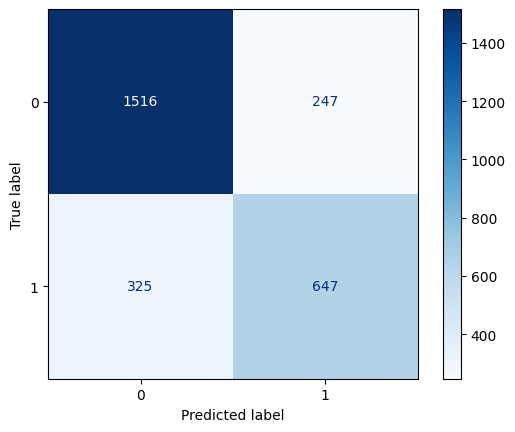

In [55]:
showModelConfusion(loaded_model=True)

In [56]:
import matplotlib.pyplot as plt

# 학습 결과 그래프
def showHistory(hist, loss=True):
  fig, loss_ax = plt.subplots()
  acc_ax = loss_ax.twinx()

  if loss:
    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

  else:
    acc_ax.plot(hist.history['acc'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
    acc_ax.set_xlabel('epoch')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper left')
  
  plt.show()
  

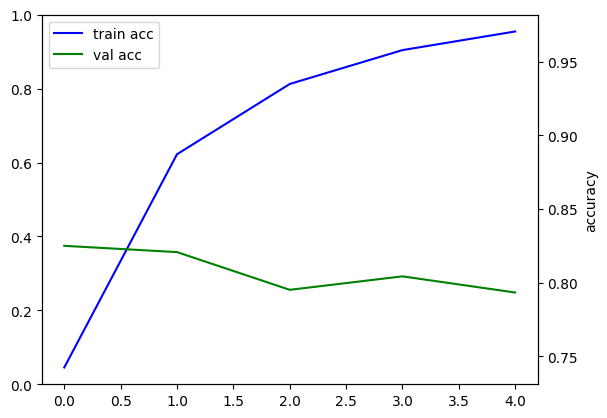

In [61]:
# # 학습결과 그래프
# showHistory(history_LSTM, loss=False)

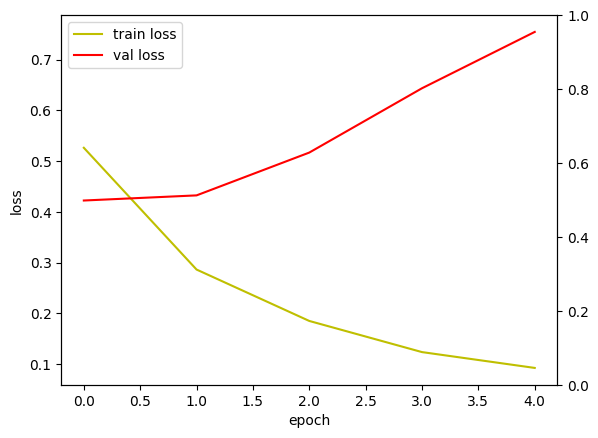

In [60]:
# # 학습결과 그래프
# showHistory(history_LSTM, loss=True)

In [59]:
# #학습 후 모델 구글 드라이브에 저장시 사용
# !mv /content/CNN_LSTM_best_model.h5 /content/drive/MyDrive/abuse_division/data
# !mv /content/LSTM_best_model.h5 /content/drive/MyDrive/abuse_division/data
# !mv /content/CNN_best_model.h5 /content/drive/MyDrive/abuse_division/data